# Mauna Loa CO2 scikit-learn example

We are going to use [scikit-learn Mauna Loa CO2 example](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html) data to train a GpMix surrogate model.

## Dataset retrieval 

You can skip this section if you already have the Mauna Loa CO2 dataset.

In [1]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


In [2]:
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


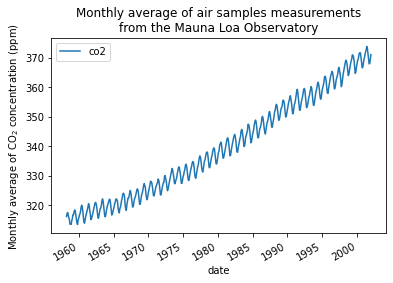

In [3]:
import matplotlib.pyplot as plt

co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data.plot()
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

In [4]:
import numpy as np
X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy().reshape(-1, 1)
np.save("mauna_loa_co2_X.npy", X)
np.save("mauna_loa_co2_y.npy", y)

## Dataset inspection

In [5]:
import numpy as np
import matplotlib.pyplot as plt

X = np.load("mauna_loa_co2_X.npy")
y = np.load("mauna_loa_co2_y.npy")
print(X.shape)
print(y.shape)

(521, 1)
(521, 1)


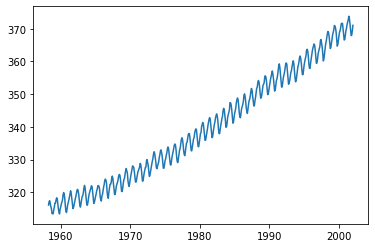

In [6]:
plt.plot(X, y)

## GpMix training

In [7]:
import egobox as egx

# We train with linear regression and matern52 correlation models
gpmix = egx.GpMix(regr_spec=egx.RegressionSpec.LINEAR, corr_spec=egx.CorrelationSpec.MATERN52)
# When in doubt you can train on all regression/correlation combinations, but it takes more time
# gpmix = egx.GpMix(regr_spec=egx.RegressionSpec.ALL, corr_spec=egx.CorrelationSpec.ALL)
gpmix.set_training_values(X, y)
gpx = gpmix.train()

## Gpx test

In [8]:
X_test = np.linspace(start=1958, stop=2000, num=100).reshape(-1, 1)
y_test = gpx.predict_values(X_test)

In [9]:
y_pred = gpx.predict_values(X_test)

(100, 1)
(100, 1)


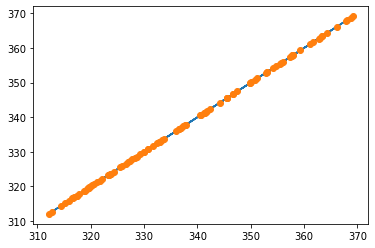

In [10]:
plt.plot(y_test, y_test, '-')
plt.plot(y_test, y_pred, 'o')
print(y_test.shape)
print(y_pred.shape)

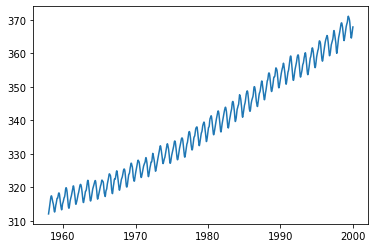

In [11]:
X_test = np.linspace(start=1958, stop=2000, num=1000).reshape(-1, 1)
y_test = gpx.predict_values(X_test)
plt.plot(X_test, y_test)

In [12]:
help(egx.GpMix)

Help on class GpMix in module builtins:

class GpMix(object)
 |  Gaussian processes mixture builder
 |  
 |  n_clusters (int >= 0)
 |      Number of clusters used by the mixture of surrogate experts.
 |      When set to 0, the number of cluster is determined automatically and refreshed every
 |      10-points addition (should say 'tentative addition' because addition may fail for some points
 |      but it is counted anyway).
 |  
 |  regr_spec (RegressionSpec flags, an int in [1, 7]):
 |      Specification of regression models used in mixture.
 |      Can be RegressionSpec.CONSTANT (1), RegressionSpec.LINEAR (2), RegressionSpec.QUADRATIC (4) or
 |      any bit-wise union of these values (e.g. RegressionSpec.CONSTANT | RegressionSpec.LINEAR)
 |  
 |  corr_spec (CorrelationSpec flags, an int in [1, 15]):
 |      Specification of correlation models used in mixture.
 |      Can be CorrelationSpec.SQUARED_EXPONENTIAL (1), CorrelationSpec.ABSOLUTE_EXPONENTIAL (2),
 |      CorrelationSpec.MA

In [13]:
help(egx.Gpx)

Help on class Gpx in module builtins:

class Gpx(object)
 |  A trained Gaussian processes mixture
 |  
 |  Methods defined here:
 |  
 |  predict_values(...)
 |      Predict output values at nsamples points.
 |      
 |      Parameters
 |          x (array[nsamples, nx])
 |              input values
 |      
 |      Returns
 |          the output values at nsamples x points (array[nsamples, 1])
 |  
 |  predict_variances(...)
 |      Predict variances at nsample points.
 |      
 |      Parameters
 |          x (array[nsamples, nx])
 |              input values
 |      
 |      Returns
 |          the variances of the output values at nsamples input points (array[nsamples, 1])
 |  
 |  save(...)
 |      Save Gaussian processes mixture in a json file.
 |      
 |      Parameters
 |          filename (string)
 |              json file generated in the current directory
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |